### Mixed precision


Mixed precision training is the use of lower-precision operations (float16 and bfloat16) in a model during training to make it run faster and use less memory. Using mixed precision can improve performance by more than 3 times on modern GPUs and 60% on TPUs.

In [1]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


### Import libraries


In [ ]:
!pip install keras

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import keras

from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split

seed = 7

### Connect to GDrive


In [3]:
from google.colab import drive

drive.mount('/gdrive')

# write path to the folder with trainig_set_no_outliers.npz
%cd '/gdrive/My Drive/'

Mounted at /gdrive
/gdrive/My Drive


### Load Data

In [4]:
# to create training set without outliers, first look at the DeleteOutliers.ipynb
data = np.load('trainig_set_no_outliers.npz')
X = data['images']
y = data['labels']
labels = np.unique(y)
print(f'Unique labels are: {labels}')

Unique labels are: [0 1 2 3 4 5 6 7]


### Look at the distribution of Data


(array([ 848., 2177., 1085., 2020.,  849.,  991., 2330., 1643.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

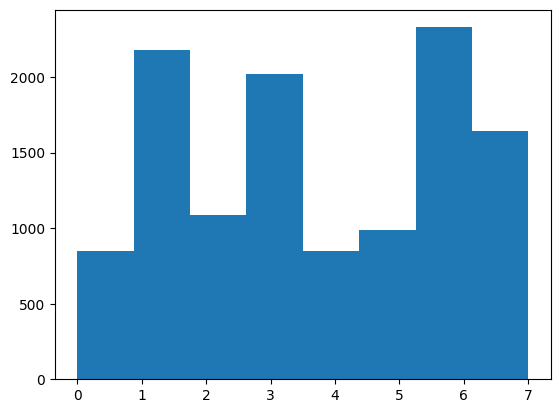

In [6]:
plt.hist(y, bins = 8)

### Normalize Data

In [5]:
if X.max()>1:
  X = (X/255).astype("float32")

print(f'Maximum value of X is {X.max()}')

Maximum value of X is 1.0


### Train Val Test split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=int(X.shape[0]*0.2),
    random_state=seed,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val,
    y_val,
    test_size=int(X_val.shape[0]*0.2),
    random_state=seed,
    stratify=y_val
)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

In [7]:
print(f'X_train shape is {X_train.shape}')
print(f'X_val shape is {X_val.shape}')
print(f'X_test shape is {X_test.shape}')

X_train shape is (9555, 96, 96, 3)
X_val shape is (1911, 96, 96, 3)
X_test shape is (477, 96, 96, 3)


In [37]:
# check if y is one-hot encoded right
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 1.])

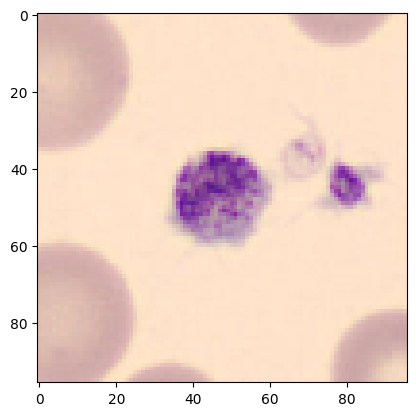

In [126]:
plt.imshow(X_train[49])

### Build the Model

In [8]:
# load backbone
mobilenet = keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    classifier_activation="softmax",
    name="mobilenetv2",
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
# set all layers to be not trainable
for layer in mobilenet.layers:
    layer.trainable = False

In [10]:
# unfreeze some layers
for i, layer in enumerate(mobilenet.layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
      if i>100:
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

101 block_11_depthwise DepthwiseConv2D True
104 block_11_project Conv2D True
107 block_12_expand Conv2D True
110 block_12_depthwise DepthwiseConv2D True
113 block_12_project Conv2D True
116 block_13_expand Conv2D True
120 block_13_depthwise DepthwiseConv2D True
123 block_13_project Conv2D True
125 block_14_expand Conv2D True
128 block_14_depthwise DepthwiseConv2D True
131 block_14_project Conv2D True
134 block_15_expand Conv2D True
137 block_15_depthwise DepthwiseConv2D True
140 block_15_project Conv2D True
143 block_16_expand Conv2D True
146 block_16_depthwise DepthwiseConv2D True
149 block_16_project Conv2D True
151 Conv_1 Conv2D True


In [26]:
def build_model(
    input_shape,
    output_shape,
    learning_rate,
    augmentation,
    mobilenet,
    seed=seed
):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='Input')
    x = augmentation(inputs)
    x = mobilenet(x)

    x = tfkl.GlobalAveragePooling2D()(x)

    x = tfkl.Dense(units=256, name='dense1')(x)
    x = tfkl.Dense(units=128, name='dense2')(x)
    x = tfkl.Dense(units=64, name='dense3')(x)
    x = tfkl.Dense(units=output_shape, name='dense4')(x)
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=5000,
      decay_rate=0.99
    )
    optimizer = tfk.optimizers.SGD(learning_rate=lr_schedule)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

### Define the model

In [27]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [28]:
# Number of training epochs
epochs = 1000

# Batch size for training
batch_size = 128

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 1000
Batch Size: 128
Learning Rare: 0.001


In [29]:
# add augmentation
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.1, value_range=(0,1)),
    tfkl.RandomContrast(0.1),
])

In [30]:
model = build_model(input_shape,
                    output_shape,
                    learning_rate,
                    augmentation,
                    mobilenet,
                    )

In [31]:
# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ cast_2 (Cast)                       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ sequential_2 (Sequential)           │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip_1 (RandomFlip)     │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_2           │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation_1              │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_zoom_1 (RandomZoom)     │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_brightness_1            │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomBrightness)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_contrast_1              │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomContrast)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mobilenetv2 (Functional)            │ (None, 3, 3, 1280)           │     2,257,984 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ Conv1 (Conv2D)                 │ (None, 48, 48, 32)           │           864 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ bn_Conv1 (BatchNormalization)  │ (None, 48, 48, 32)           │           128 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ Conv1_relu (ReLU)              │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ expanded_conv_depthwise        │ (None, 48, 48, 32)           │           288 │    N    │
│ (DepthwiseConv2D)                   │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ expanded_conv_depthwise_BN     │ (None, 48, 48, 32)           │           128 │    N    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ expanded_conv_de

 Total params: 2,627,592 (10.02 MB)

 Trainable params: 2,209,224 (8.43 MB)

 Non-trainable params: 418,368 (1.60 MB)

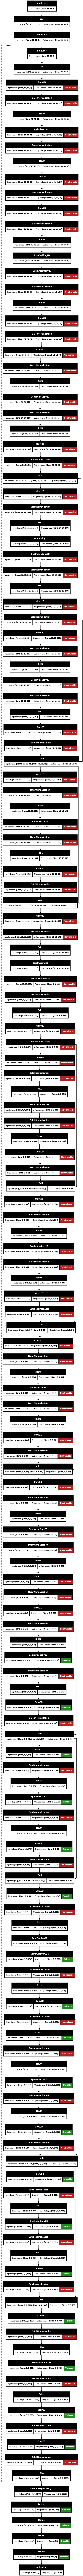

In [32]:
# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

### Train the model


In [16]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [17]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'MobilenetV2'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - accuracy: 0.1435 - loss: 4.2685 - val_accuracy: 0.1968 - val_loss: 1.9396
Epoch 2/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2693 - loss: 1.8981 - val_accuracy: 0.4720 - val_loss: 1.4715
Epoch 3/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5348 - loss: 1.2552 - val_accuracy: 0.7870 - val_loss: 0.6736
Epoch 4/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7423 - loss: 0.7348 - val_accuracy: 0.8237 - val_loss: 0.5334
Epoch 5/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8095 - loss: 0.5431 - val_accuracy: 0.8765 - val_loss: 0.3586
Epoch 6/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8337 - loss: 0.4962 - val_accuracy: 0.8765 - val_loss: 0.3360
Epoch 7/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8713 - loss: 0.3607 - val_accuracy: 0.8844 - val_loss: 0.3337
Epoch 8/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9126 - loss: 0.2633 - val_ac

### Fine tune


In [35]:
mobilenet = tfk.models.load_model('MobilenetV296.44.keras')

# Set the MobileNetV3Small model layers as trainable
for layer in mobilenet.layers:
  layer.trainable = False

# # Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(mobilenet.get_layer("mobilenetv2").layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

1 Conv1 Conv2D True
4 expanded_conv_depthwise DepthwiseConv2D True
7 expanded_conv_project Conv2D True
9 block_1_expand Conv2D True
13 block_1_depthwise DepthwiseConv2D True
16 block_1_project Conv2D True
18 block_2_expand Conv2D True
21 block_2_depthwise DepthwiseConv2D True
24 block_2_project Conv2D True
27 block_3_expand Conv2D True
31 block_3_depthwise DepthwiseConv2D True
34 block_3_project Conv2D True
36 block_4_expand Conv2D True
39 block_4_depthwise DepthwiseConv2D True
42 block_4_project Conv2D True
45 block_5_expand Conv2D True
48 block_5_depthwise DepthwiseConv2D True
51 block_5_project Conv2D True
54 block_6_expand Conv2D True
58 block_6_depthwise DepthwiseConv2D True
61 block_6_project Conv2D True
63 block_7_expand Conv2D True
66 block_7_depthwise DepthwiseConv2D True
69 block_7_project Conv2D True
72 block_8_expand Conv2D True
75 block_8_depthwise DepthwiseConv2D True
78 block_8_project Conv2D True
81 block_9_expand Conv2D True
84 block_9_depthwise DepthwiseConv2D True
87

In [36]:
model = mobilenet
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [37]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'Mobilenet2step'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 329ms/step - accuracy: 0.7955 - loss: 1.2996 - val_accuracy: 0.9519 - val_loss: 0.1496
Epoch 2/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9501 - loss: 0.1361 - val_accuracy: 0.9508 - val_loss: 0.1503
Epoch 3/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9544 - loss: 0.1360 - val_accuracy: 0.9388 - val_loss: 0.2087
Epoch 4/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9693 - loss: 0.0962 - val_accuracy: 0.9623 - val_loss: 0.1411
Epoch 5/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9733 - loss: 0.0742 - val_accuracy: 0.9628 - val_loss: 0.1209
Epoch 6/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9763 - loss: 0.0672 - val_accuracy: 0.9702 - val_loss: 0.0911
Epoch 7/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9856 - loss: 0.0492 - val_accuracy: 0.9508 - val_loss: 0.1665
Epoch 8/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9829 - loss: 0.0460 - val_ac

### Plot the training history

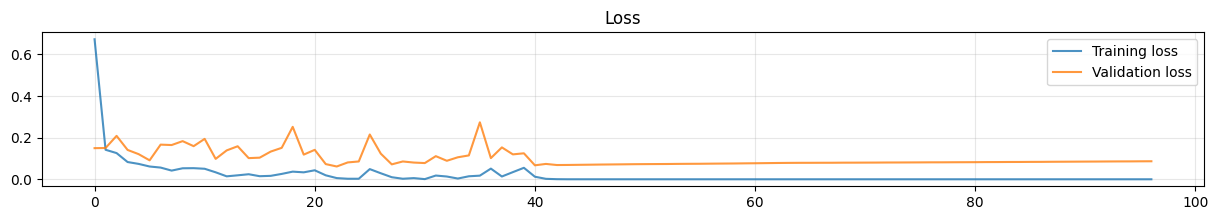

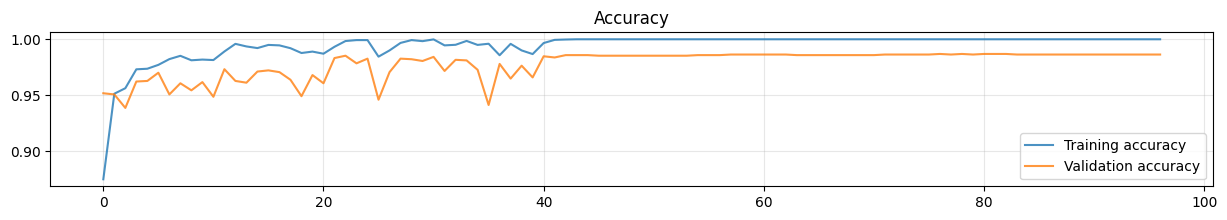

In [38]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

### Make inference

In [41]:
model = tfk.models.load_model('Mobilenet2step98.69.keras')

(array([[0.00e+00, 1.19e-07, 2.98e-07, 0.00e+00, 1.67e-05, 1.00e+00,
         0.00e+00, 0.00e+00]], dtype=float16),
 array([5], dtype=uint8))

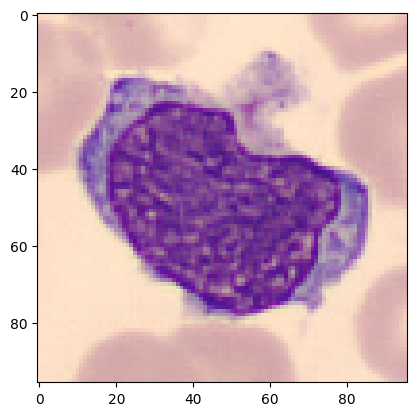

In [42]:
idx = 40
plt.imshow(X_test[idx])
gt =y_test[idx]

pred = model.predict(np.expand_dims(X_test[idx], axis = 0),  verbose=0)
pred, gt

In [45]:
if np.max(X_test)>1:
  X_test = (X_test/255).astype("float32")

predictions = model.predict(X_test, verbose=0)
pred_classes = np.argmax(predictions, axis=-1)
if y_test.shape[1]!=1:
  gt = np.argmax(y_test, axis=1)
else:
  gt = y_test[:, 0]
accuracy = sum(gt == pred_classes) / len(gt)
print(f'Test accuracy {accuracy}')

Test accuracy 0.9811320754716981


### Simple Submission


In [47]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('Mobilenet2step98.69.keras')


    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        if np.max(X)>1:
          X = (X/255).astype("float32")

        preds = self.neural_network.predict(X, verbose=0)

        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [48]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py 'Mobilenet2step98.69.keras'

from google.colab import files
files.download(filename)

  adding: model.py (deflated 54%)
  adding: Mobilenet2step98.69.keras (deflated 11%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
del X_train
del X_val
del y_train
del y_val
del X
del y